In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import seaborn as sns
sns.set() 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms.v2 as transforms

from collections import defaultdict
from typing import List, Optional, Callable, Dict
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
from PIL import Image
import numpy as np
from pyquaternion import Quaternion
from einops import rearrange
import pandas as pd

from lightning.pytorch.utilities import move_data_to_device

In [6]:
from world_model.dataloader.components.random_tokenized_sequence_nuscenes import RandomTokenizedSequenceNuscenesDataset
from world_model.dataloader.tokenized_sequence_nuscenes import custom_collate
from world_model.dataloader.components.transforms import CropAndResizeTransform, Normalize
from world_model.utils import  RankedLogger

In [14]:
from world_model.sequence_adapters.gpt_adapter import GPTAdapter
from world_model.action_tokenizers.random_speed_and_curvature import RandSpeedAndCurvatureTokens
from world_model.utils.generation import TopKSampler, autoregressive_image_sequence_generation
from world_model.networks.gpt2 import GPT2

from world_model.networks.mup_gpt2 import MuGPT2

In [15]:
nuscene_pickle_path = "/datasets_local/nuscenes_pickle/mini_data.pkl"
nuscenes_root_dir = "/datasets_local/nuscenes"
quantized_nuscenes_root_dir = Path('/datasets_local/nuscenes_tokenized/VQGAN_ImageNet_f16_1024')

In [16]:
with open(nuscene_pickle_path, 'rb') as f:
    nuscenes_data = pickle.load(f)

In [17]:
for split in ['val', 'train']:
    nuscenes_split_data = nuscenes_data[split]
    # sort by scene and timestamp
    nuscenes_split_data.sort(key=lambda x: (x['scene']['name'], x['CAM_FRONT']['timestamp']))
    
    nuscenes_scenes_length = defaultdict(int)
    for sample in nuscenes_split_data:
        nuscenes_scenes_length[sample['scene']['name']] += 1

    
    min_seq_lenght = min(nuscenes_scenes_length.values())
    max_seq_lenght = max(nuscenes_scenes_length.values())
    
    print(split)
    print(len(nuscenes_scenes_length))
    print(min_seq_lenght)
    print(max_seq_lenght)

    print('-'*40)

val
2
40
41
----------------------------------------
train
8
39
41
----------------------------------------


In [18]:
def run_forward(batch, model, action_tokenizer, sequence_adapter):
    action_tokens = action_tokenizer(**batch)
    visual_tokens = batch['visual_tokens']

    sequence_data = sequence_adapter(visual_tokens, action_tokens)
    
    input_data = {
        'token_sequence': sequence_data['token_sequence'][:, :-1],
        'spatial_positions': sequence_data['spatial_positions'][:, :-1],
        'temporal_positions': sequence_data['temporal_positions'][:, :-1],
    }
    
    # Create target_tokens by taking all but the first token (shifting by one)
    target_data = {
        'token_sequence': sequence_data['token_sequence'][:, 1:],
        'visual_tokens_mask': sequence_data['visual_tokens_mask'][:, 1:]
    }

    
    logits_sequence = model(**input_data)
    visual_logits = logits_sequence[target_data['visual_tokens_mask']]
    
    visual_target_tokens = target_data['token_sequence'][target_data['visual_tokens_mask']]
    
    loss = F.cross_entropy(visual_logits, visual_target_tokens)

    return loss
    

In [78]:
dim_per_head = 64
nb_timesteps = 1
nb_layers = 12

In [79]:
dataset = RandomTokenizedSequenceNuscenesDataset(
    nuscenes_root_dir = nuscenes_root_dir, 
    quantized_nuscenes_root_dir = quantized_nuscenes_root_dir,
    nuscenes_pickle_data = nuscenes_data['train'], 
    sequence_length = nb_timesteps,
    load_image = False,
)

In [80]:
dataloader = DataLoader(
    dataset,
    drop_last=False,
    batch_size=1,
    collate_fn=custom_collate,
    shuffle=False
)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
action_tokenizer = RandSpeedAndCurvatureTokens(
    speed_vocab_size = 50,
    curvature_vocab_size = 80,
)
action_tokenizer.to(device)

RandSpeedAndCurvatureTokens()

In [83]:
sequence_adapter = GPTAdapter(
    visual_vocab_size = 1024,
    action_vocab_sizes = [50, 80]
)
sequence_adapter.to(device)

GPTAdapter()

In [133]:
width = 128
base_model = MuGPT2(
    embedding_dim=width,
    nb_layers=nb_layers,
    nb_heads=width//dim_per_head, 
    vocabulary_size=1024+50+80, 
    nb_timesteps=nb_timesteps, 
    nb_tokens_per_timestep=352, 
    dropout_rate=0.,
    bias = True,   
    attn_mult = 8.0,
    output_mult = 8.0,
    output_tied = True,
)

# The delta model is used to automatically detect "infinite" dimensions.
# That is to say the weights matrices that changes/scales with hyper-params
# and hence requires to be properly scaled.
width = 256
delta_model = MuGPT2(
    embedding_dim=width,
    nb_layers=nb_layers,
    nb_heads=width//dim_per_head, 
    vocabulary_size=1024+50+80, 
    nb_timesteps=nb_timesteps, 
    nb_tokens_per_timestep=352, 
    dropout_rate=0.,
    bias = True,   
    attn_mult = 8.0,
    output_mult = 8.0,
    output_tied = True,
)

number of parameters: 2.53M
number of parameters: 9.77M


In [134]:
import mup
from mup import make_base_shapes, set_base_shapes

In [135]:
base_shapes = make_base_shapes(base_model, delta_model)

In [136]:
from mup.coord_check import _record_coords, plot_coord_data

In [137]:
num_backprop_iters = 3

In [146]:
def get_model(mup, width, dim_per_head, nb_timesteps, nb_layers):

    if mup:
        return MuGPT2(
            embedding_dim=width,
            nb_layers=nb_layers,
            nb_heads=width//dim_per_head, 
            attn_mult = 8.0,
            vocabulary_size=1024+50+80, 
            nb_timesteps=nb_timesteps, 
            nb_tokens_per_timestep=352, 
            init_std = 0.02,
            dropout_rate=0.,
            bias = True,   
            output_mult = 8.0,
            output_tied = True,
        )
        
    return GPT2(
        embedding_dim=width,
        nb_layers=nb_layers,
        nb_heads=width//dim_per_head, 
        vocabulary_size=1024+50+80, 
        nb_timesteps=nb_timesteps, 
        nb_tokens_per_timestep=352, 
        dropout_rate=0.,
        bias=True
    )

In [147]:
widths = 2**np.arange(7, 11)
print(widths)

[ 128  256  512 1024]


In [148]:
from torch.optim import AdamW
from mup.optim import MuAdamW

In [149]:
lr = 0.005

In [150]:
!ls 

'3d coords pos encoding.ipynb'
 COMMAND_creator.ipynb
'GPT2 model size.ipynb'
 GS_128_0-9.sh
 GS_128_10-19.sh
 GS_128_20-29.sh
 GS_128_30-39.sh
 GS_128_40-49.sh
 GS_256_0-9.sh
 GS_256_10-19.sh
 GS_256_20-29.sh
 GS_256_30-39.sh
 GS_256_40-49.sh
'Nuscenes slot VQ.ipynb'
'Nuscenes unannotated frames synchronization.ipynb'
 Torchmetrics.ipynb
'VQGAN exploration.ipynb'
 adastra_metrics.ipynb
 checkpoints
 lightning_logs
 mup_parametrization.ipynb
 mup_set_scale.ipynb


In [151]:
global_df = {}

for is_mup in [True, False]:

    df = []
    
    for width in widths:
    
        width = int(width)
    
        print(is_mup, width, width//dim_per_head)
                  
        model = get_model(is_mup, width, dim_per_head, nb_timesteps, nb_layers)
        model.to(device)
        model.train()
    
        if is_mup:
            _ = set_base_shapes(
                model,
                #base_shapes,
                './../mup_shapes/gpt2_12layers_16timesteps_basewidth128.bsh'
            )
            optimizer = MuAdamW(model.parameters(), lr=lr)
        else:
            _ = set_base_shapes(model, None)
            optimizer = AdamW(model.parameters(), lr=lr)

        # re-initialize after set_base_shapes
        model.apply(model._init_weights)
    
        for batch_idx, batch in enumerate(dataloader):
        
            batch = move_data_to_device(batch, device)
        
            model_hooks = []
            for name, module in model.named_modules():
                model_hooks.append(
                    module.register_forward_hook(
                        _record_coords(
                            df, 
                            width, 
                            name, 
                            batch_idx+1,
                        )
                    )
                )
        
            loss = run_forward(batch, model, action_tokenizer, sequence_adapter)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            for handle in model_hooks:
                handle.remove()
        
            if batch_idx == num_backprop_iters: break
    
    df = pd.DataFrame(df)

    global_df[is_mup] = df

True 128 2
number of parameters: 2.53M
True 256 4
number of parameters: 9.77M
True 512 8
number of parameters: 38.42M
True 1024 16
number of parameters: 152.34M
False 128 2
number of parameters: 2.53M
False 256 4
number of parameters: 9.77M
False 512 8
number of parameters: 38.42M
False 1024 16
number of parameters: 152.34M


In [152]:
set(global_df[False]["module"])

{'',
 'lm_head',
 'transformer.drop',
 'transformer.h.0',
 'transformer.h.0.attn',
 'transformer.h.0.attn.c_attn',
 'transformer.h.0.attn.c_proj',
 'transformer.h.0.attn.key',
 'transformer.h.0.attn.query',
 'transformer.h.0.attn.resid_dropout',
 'transformer.h.0.attn.value',
 'transformer.h.0.ln_1',
 'transformer.h.0.ln_2',
 'transformer.h.0.mlp',
 'transformer.h.0.mlp.c_fc',
 'transformer.h.0.mlp.c_proj',
 'transformer.h.0.mlp.dropout',
 'transformer.h.0.mlp.gelu',
 'transformer.h.1',
 'transformer.h.1.attn',
 'transformer.h.1.attn.c_attn',
 'transformer.h.1.attn.c_proj',
 'transformer.h.1.attn.key',
 'transformer.h.1.attn.query',
 'transformer.h.1.attn.resid_dropout',
 'transformer.h.1.attn.value',
 'transformer.h.1.ln_1',
 'transformer.h.1.ln_2',
 'transformer.h.1.mlp',
 'transformer.h.1.mlp.c_fc',
 'transformer.h.1.mlp.c_proj',
 'transformer.h.1.mlp.dropout',
 'transformer.h.1.mlp.gelu',
 'transformer.h.10',
 'transformer.h.10.attn',
 'transformer.h.10.attn.c_attn',
 'transformer.

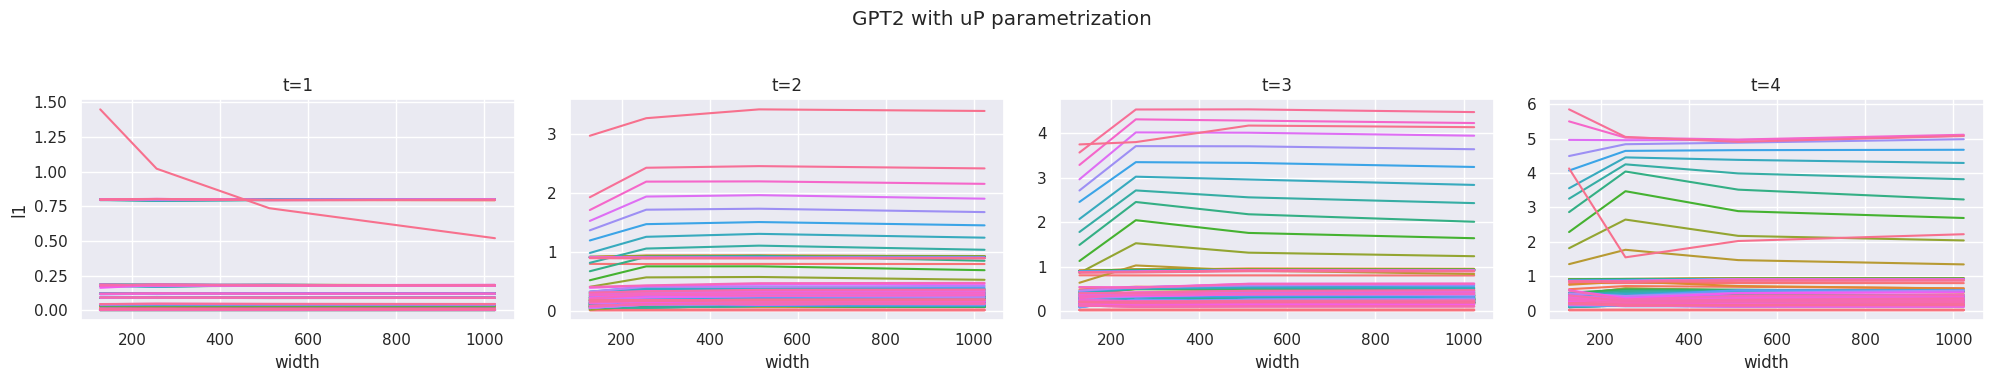

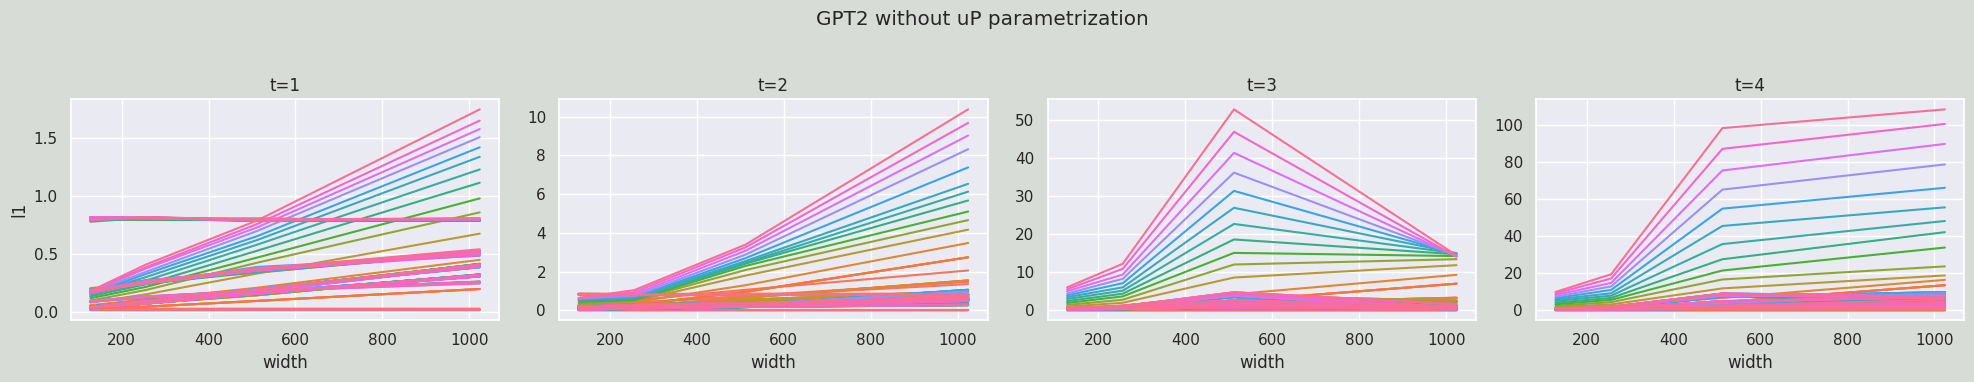

In [153]:
for is_mup in [True, False]:
    plot_coord_data(
        global_df[is_mup], 
        suptitle=f"GPT2 with{'' if is_mup else 'out'} uP parametrization",
        face_color='xkcd:light grey' if not is_mup else None,
        legend=None,
        loglog=False,
        logbase=2
    )
    plt.show()

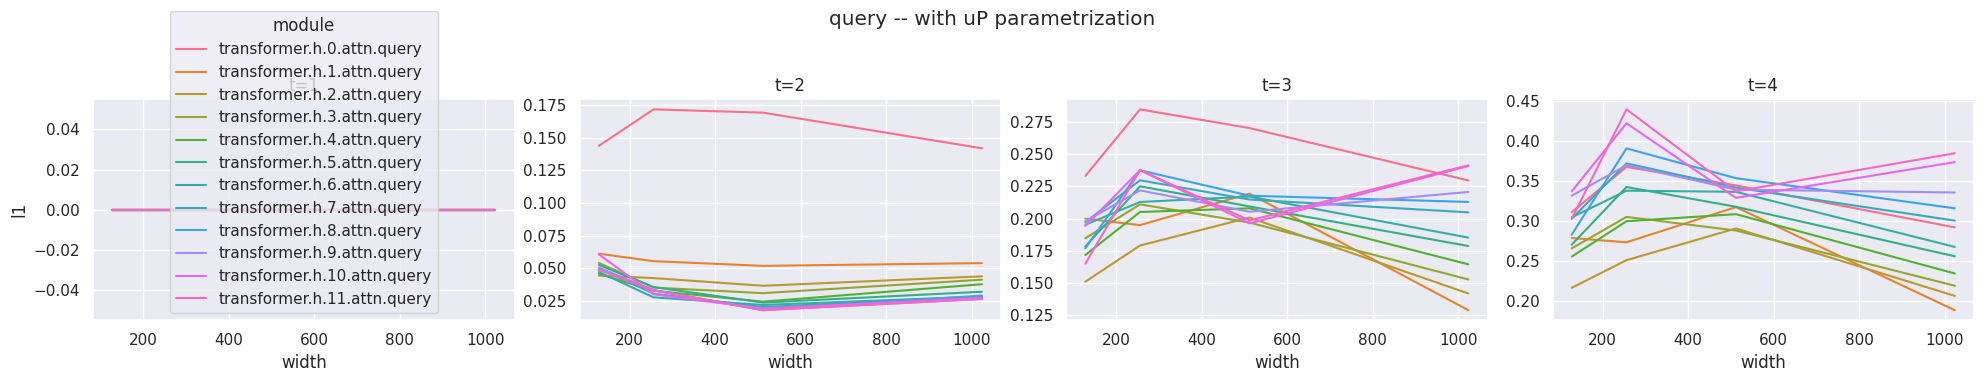

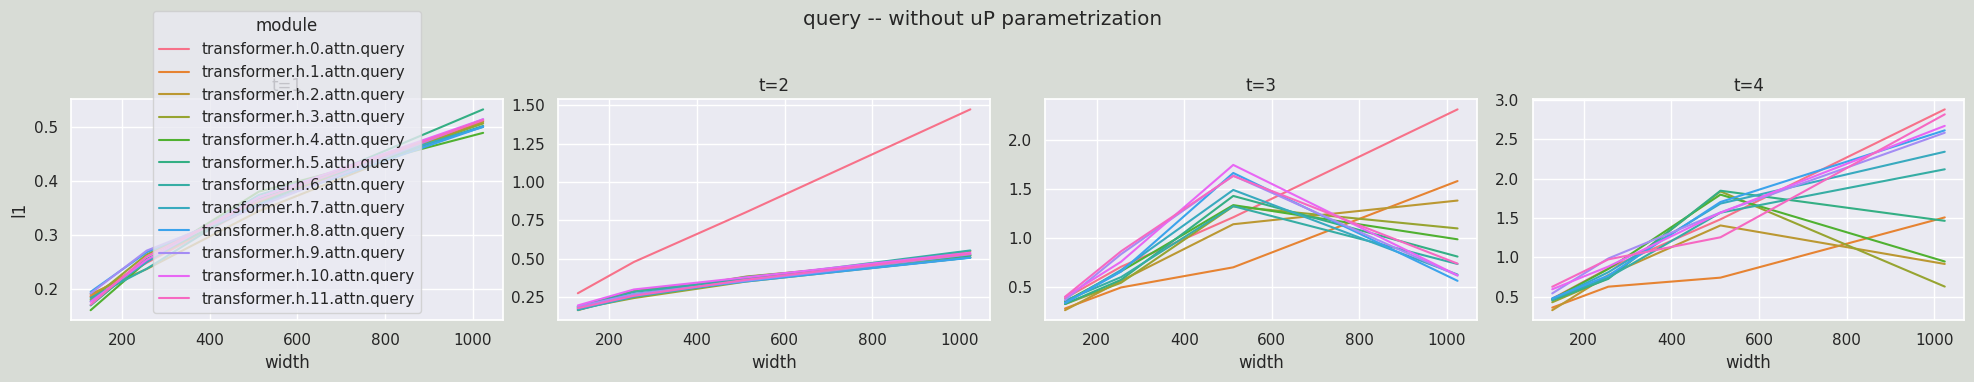

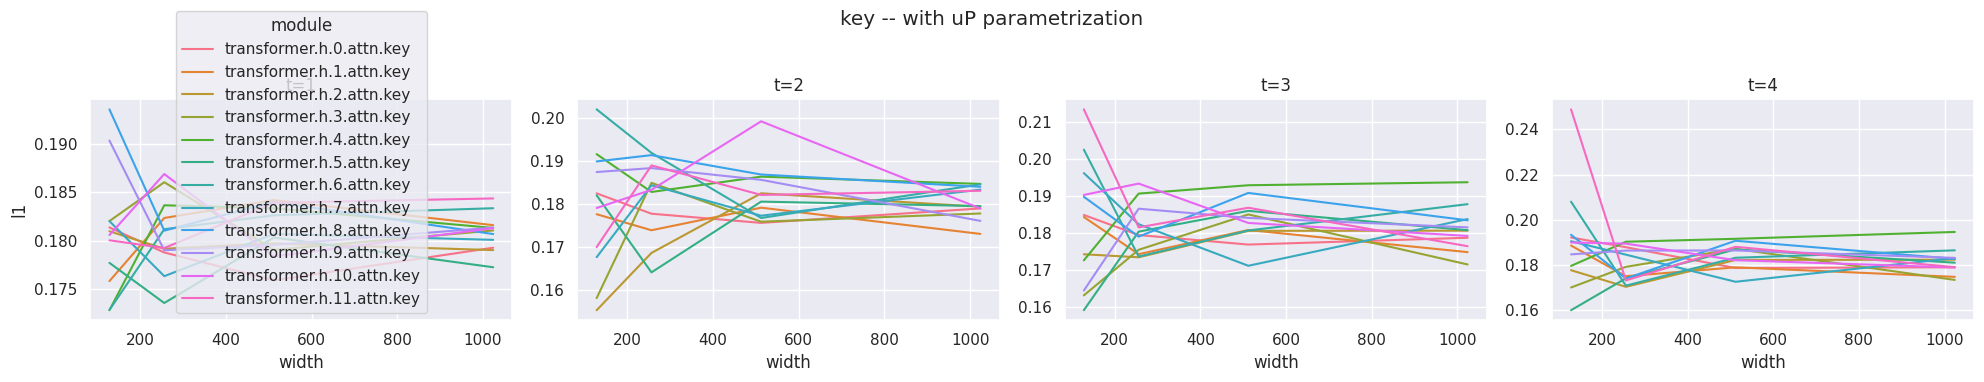

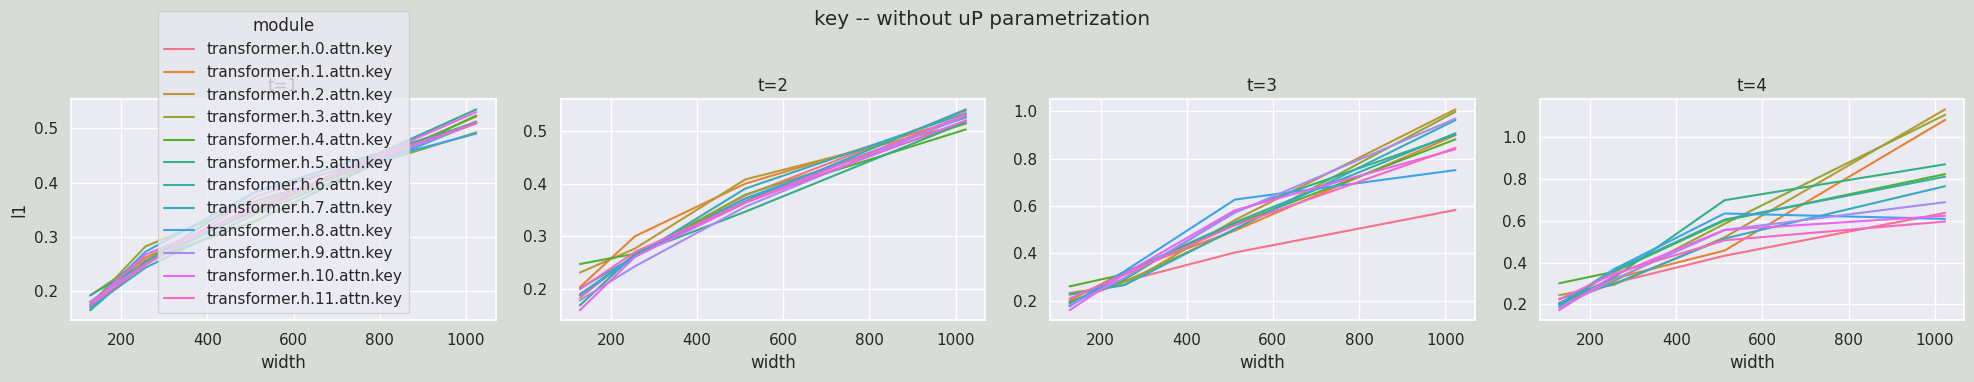

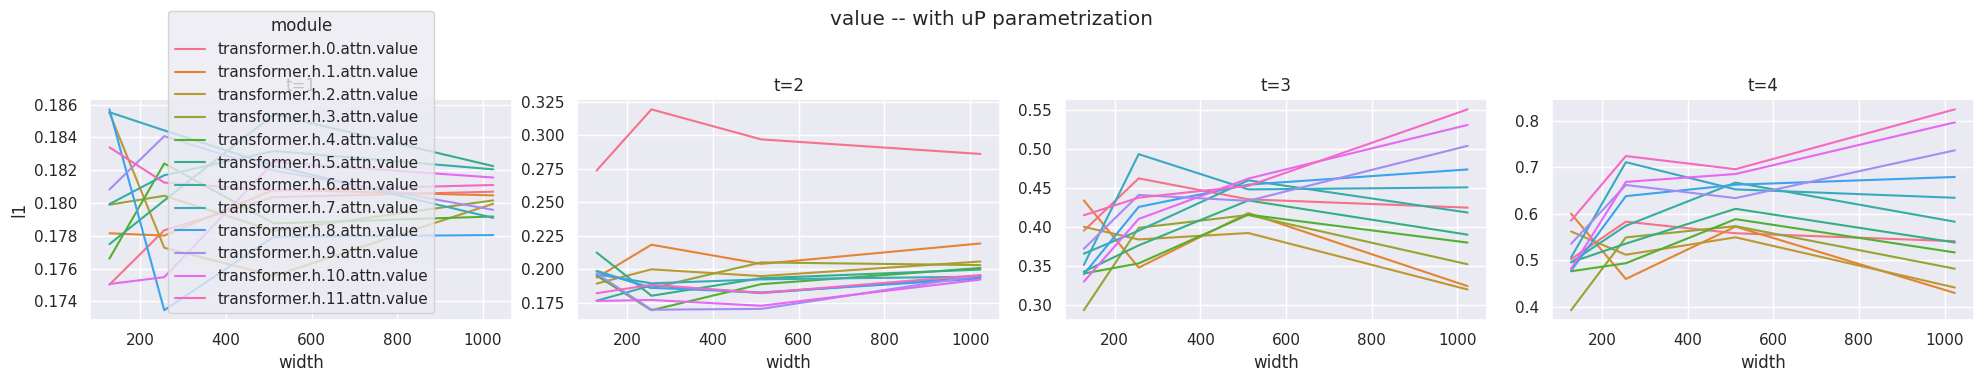

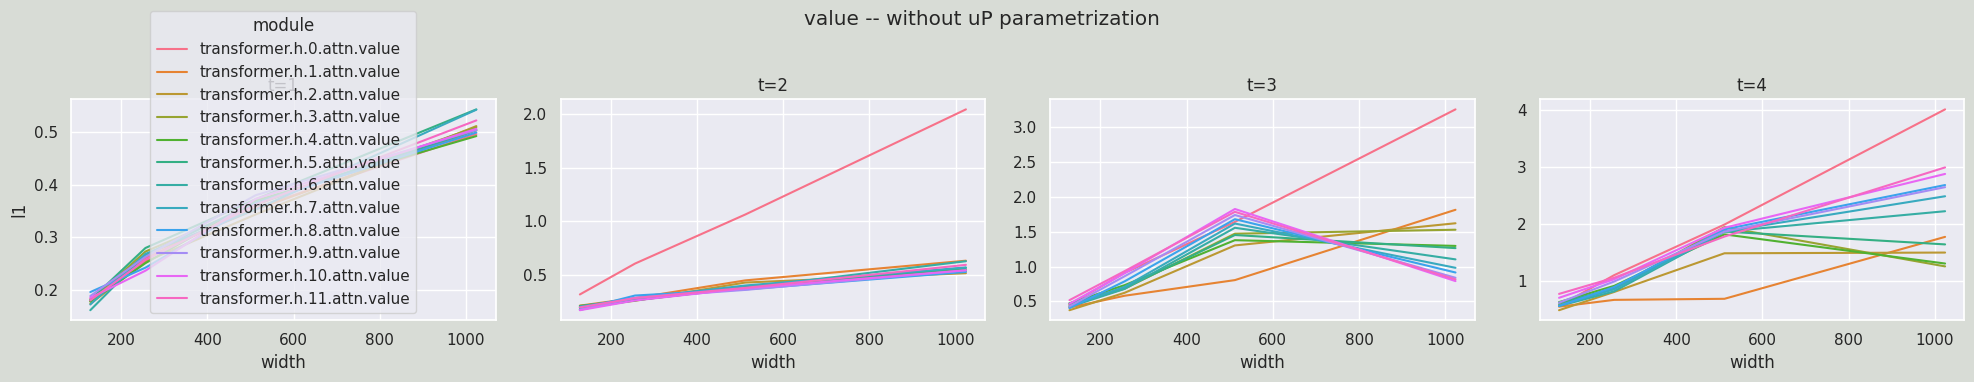

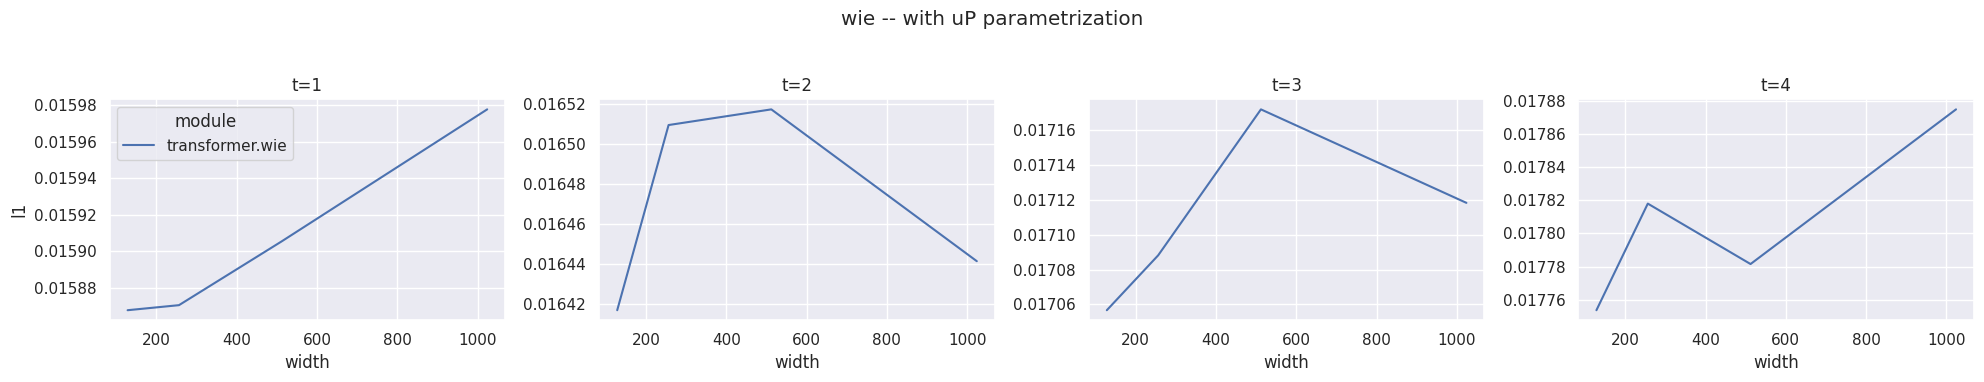

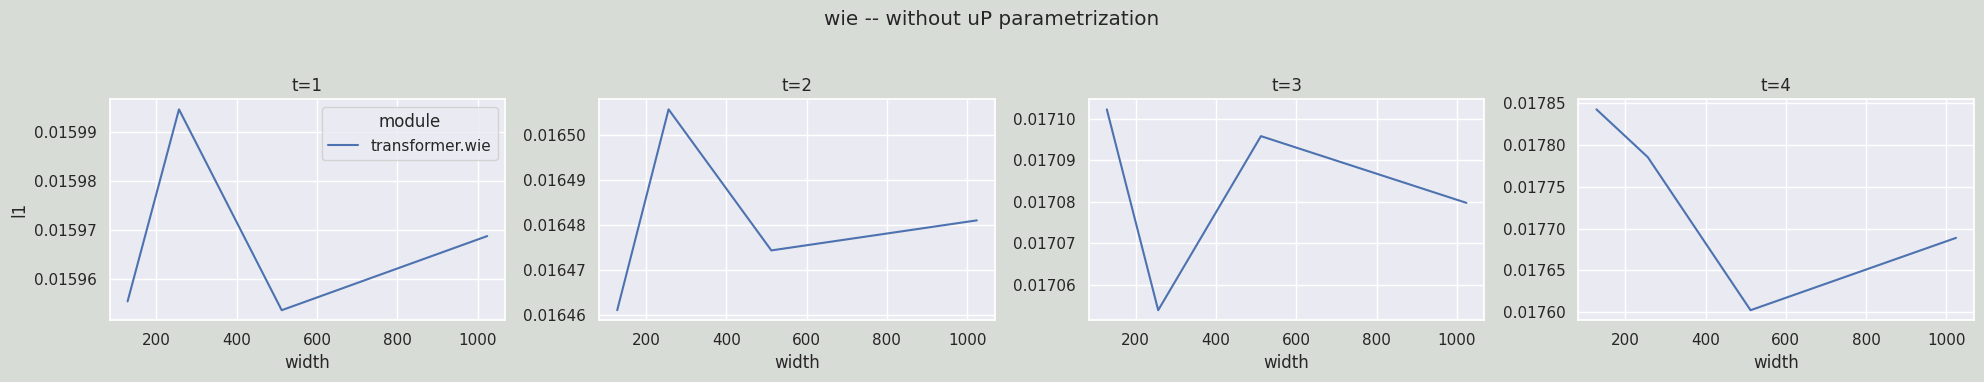

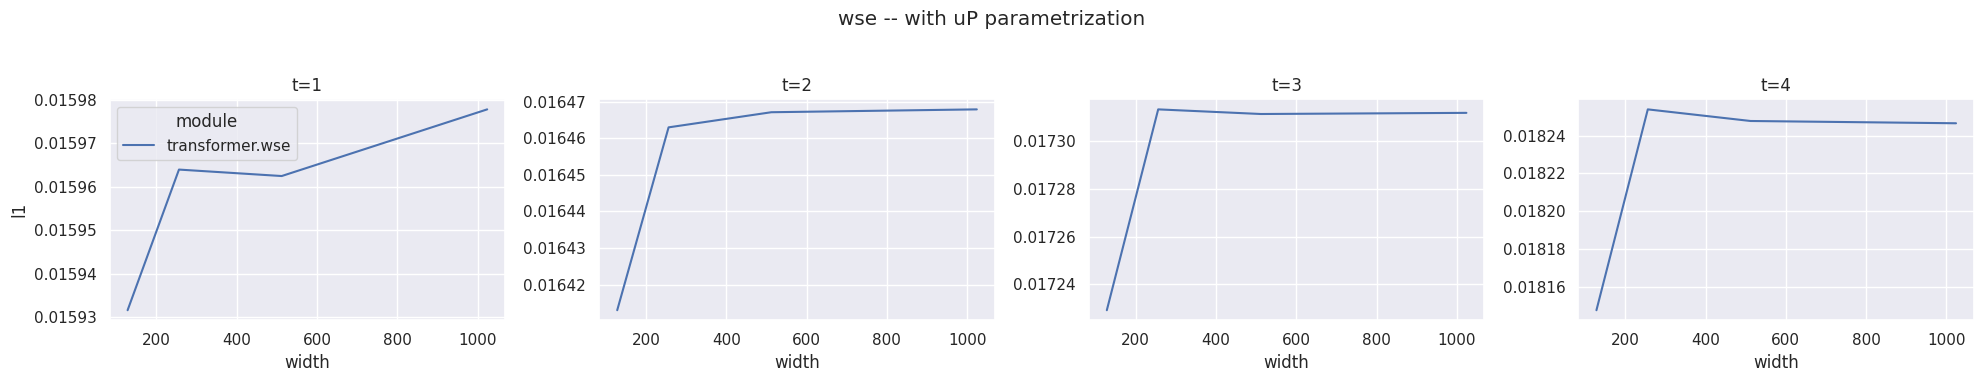

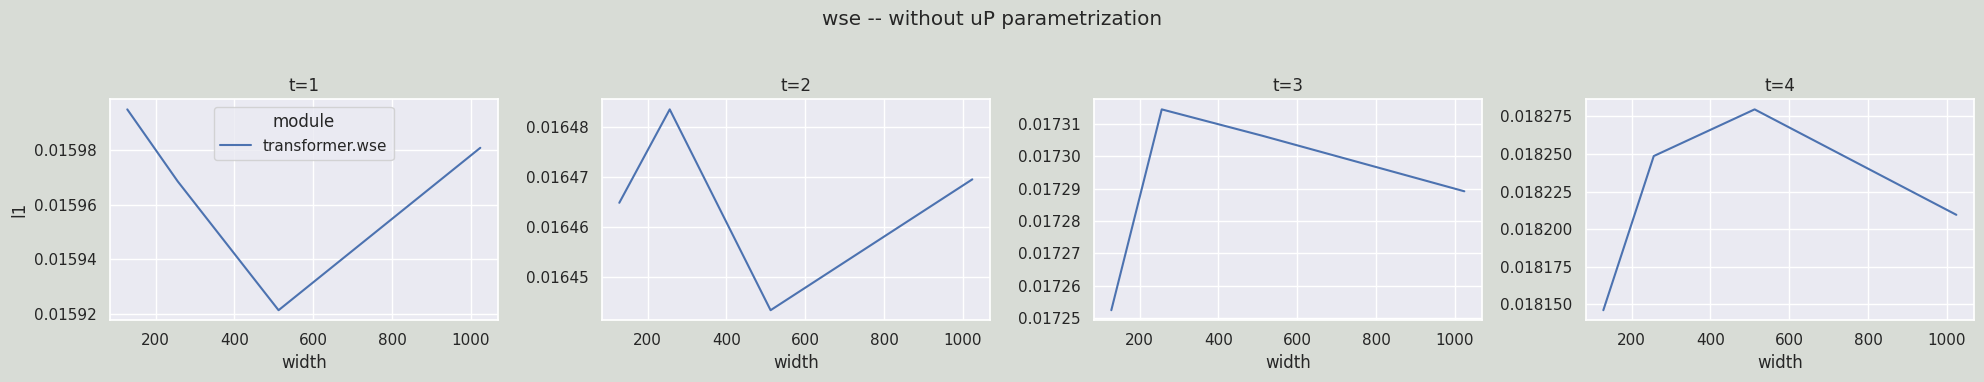

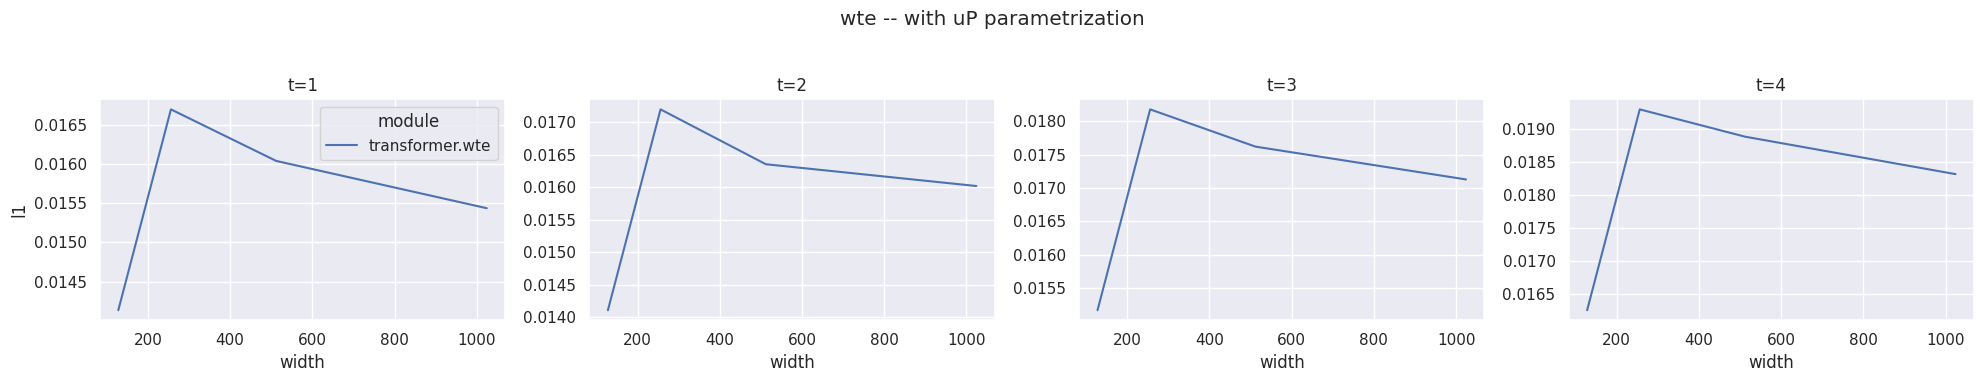

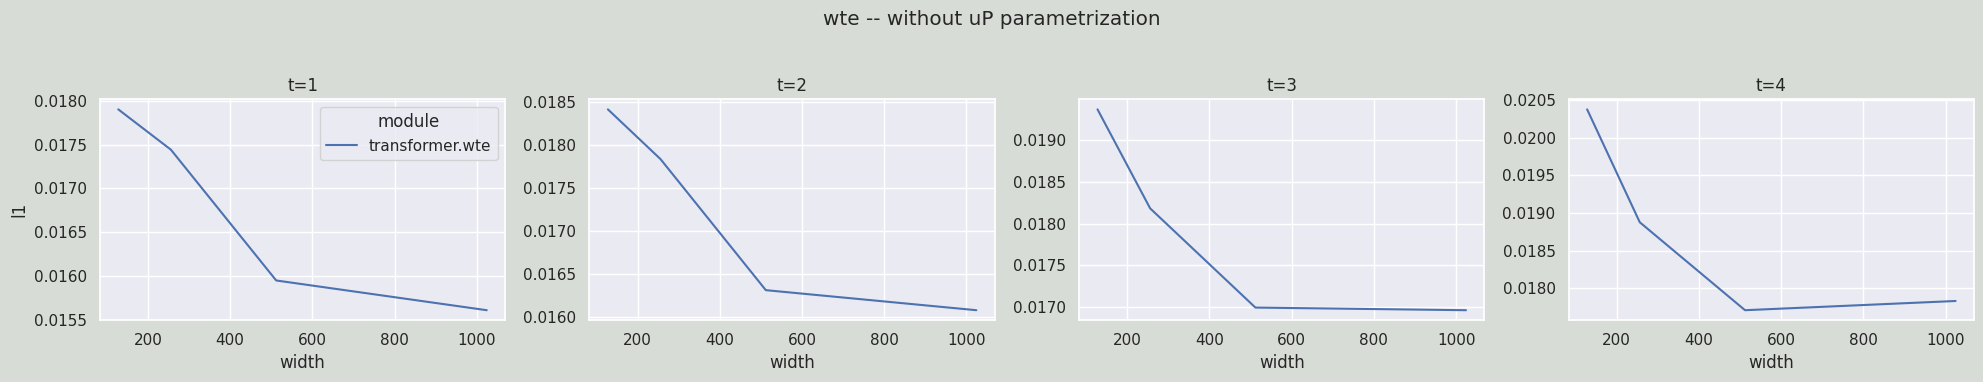

<Figure size 0x400 with 0 Axes>

<Figure size 0x400 with 0 Axes>

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


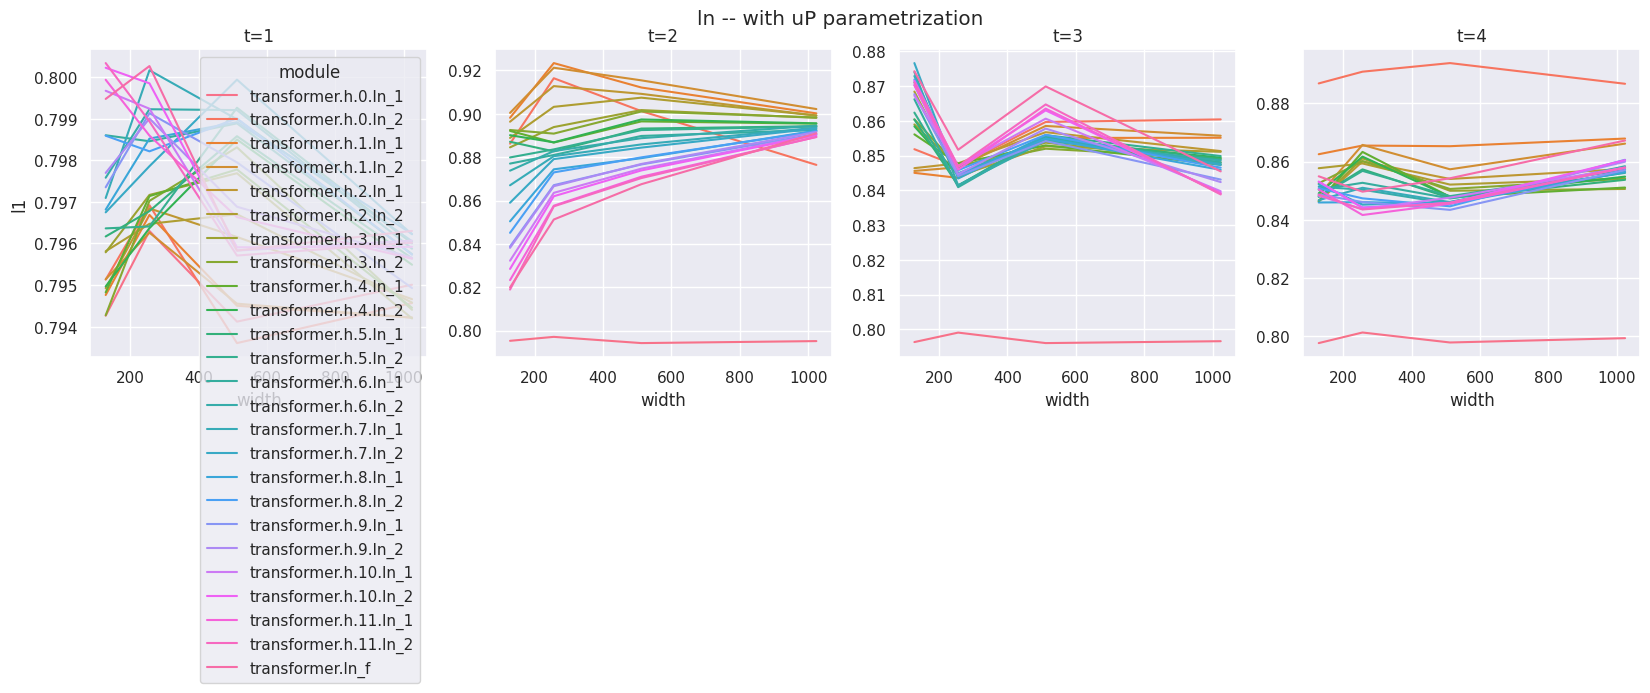

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


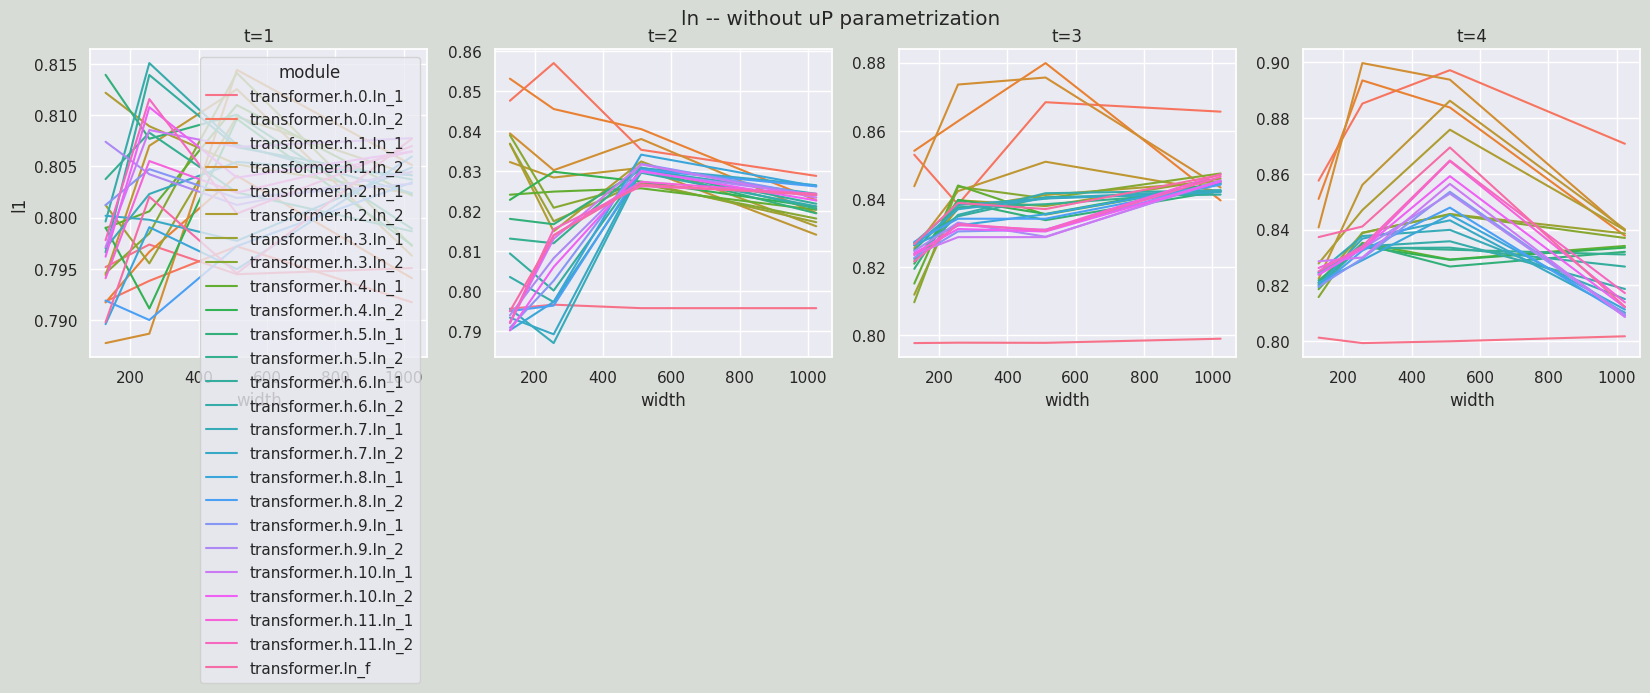

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


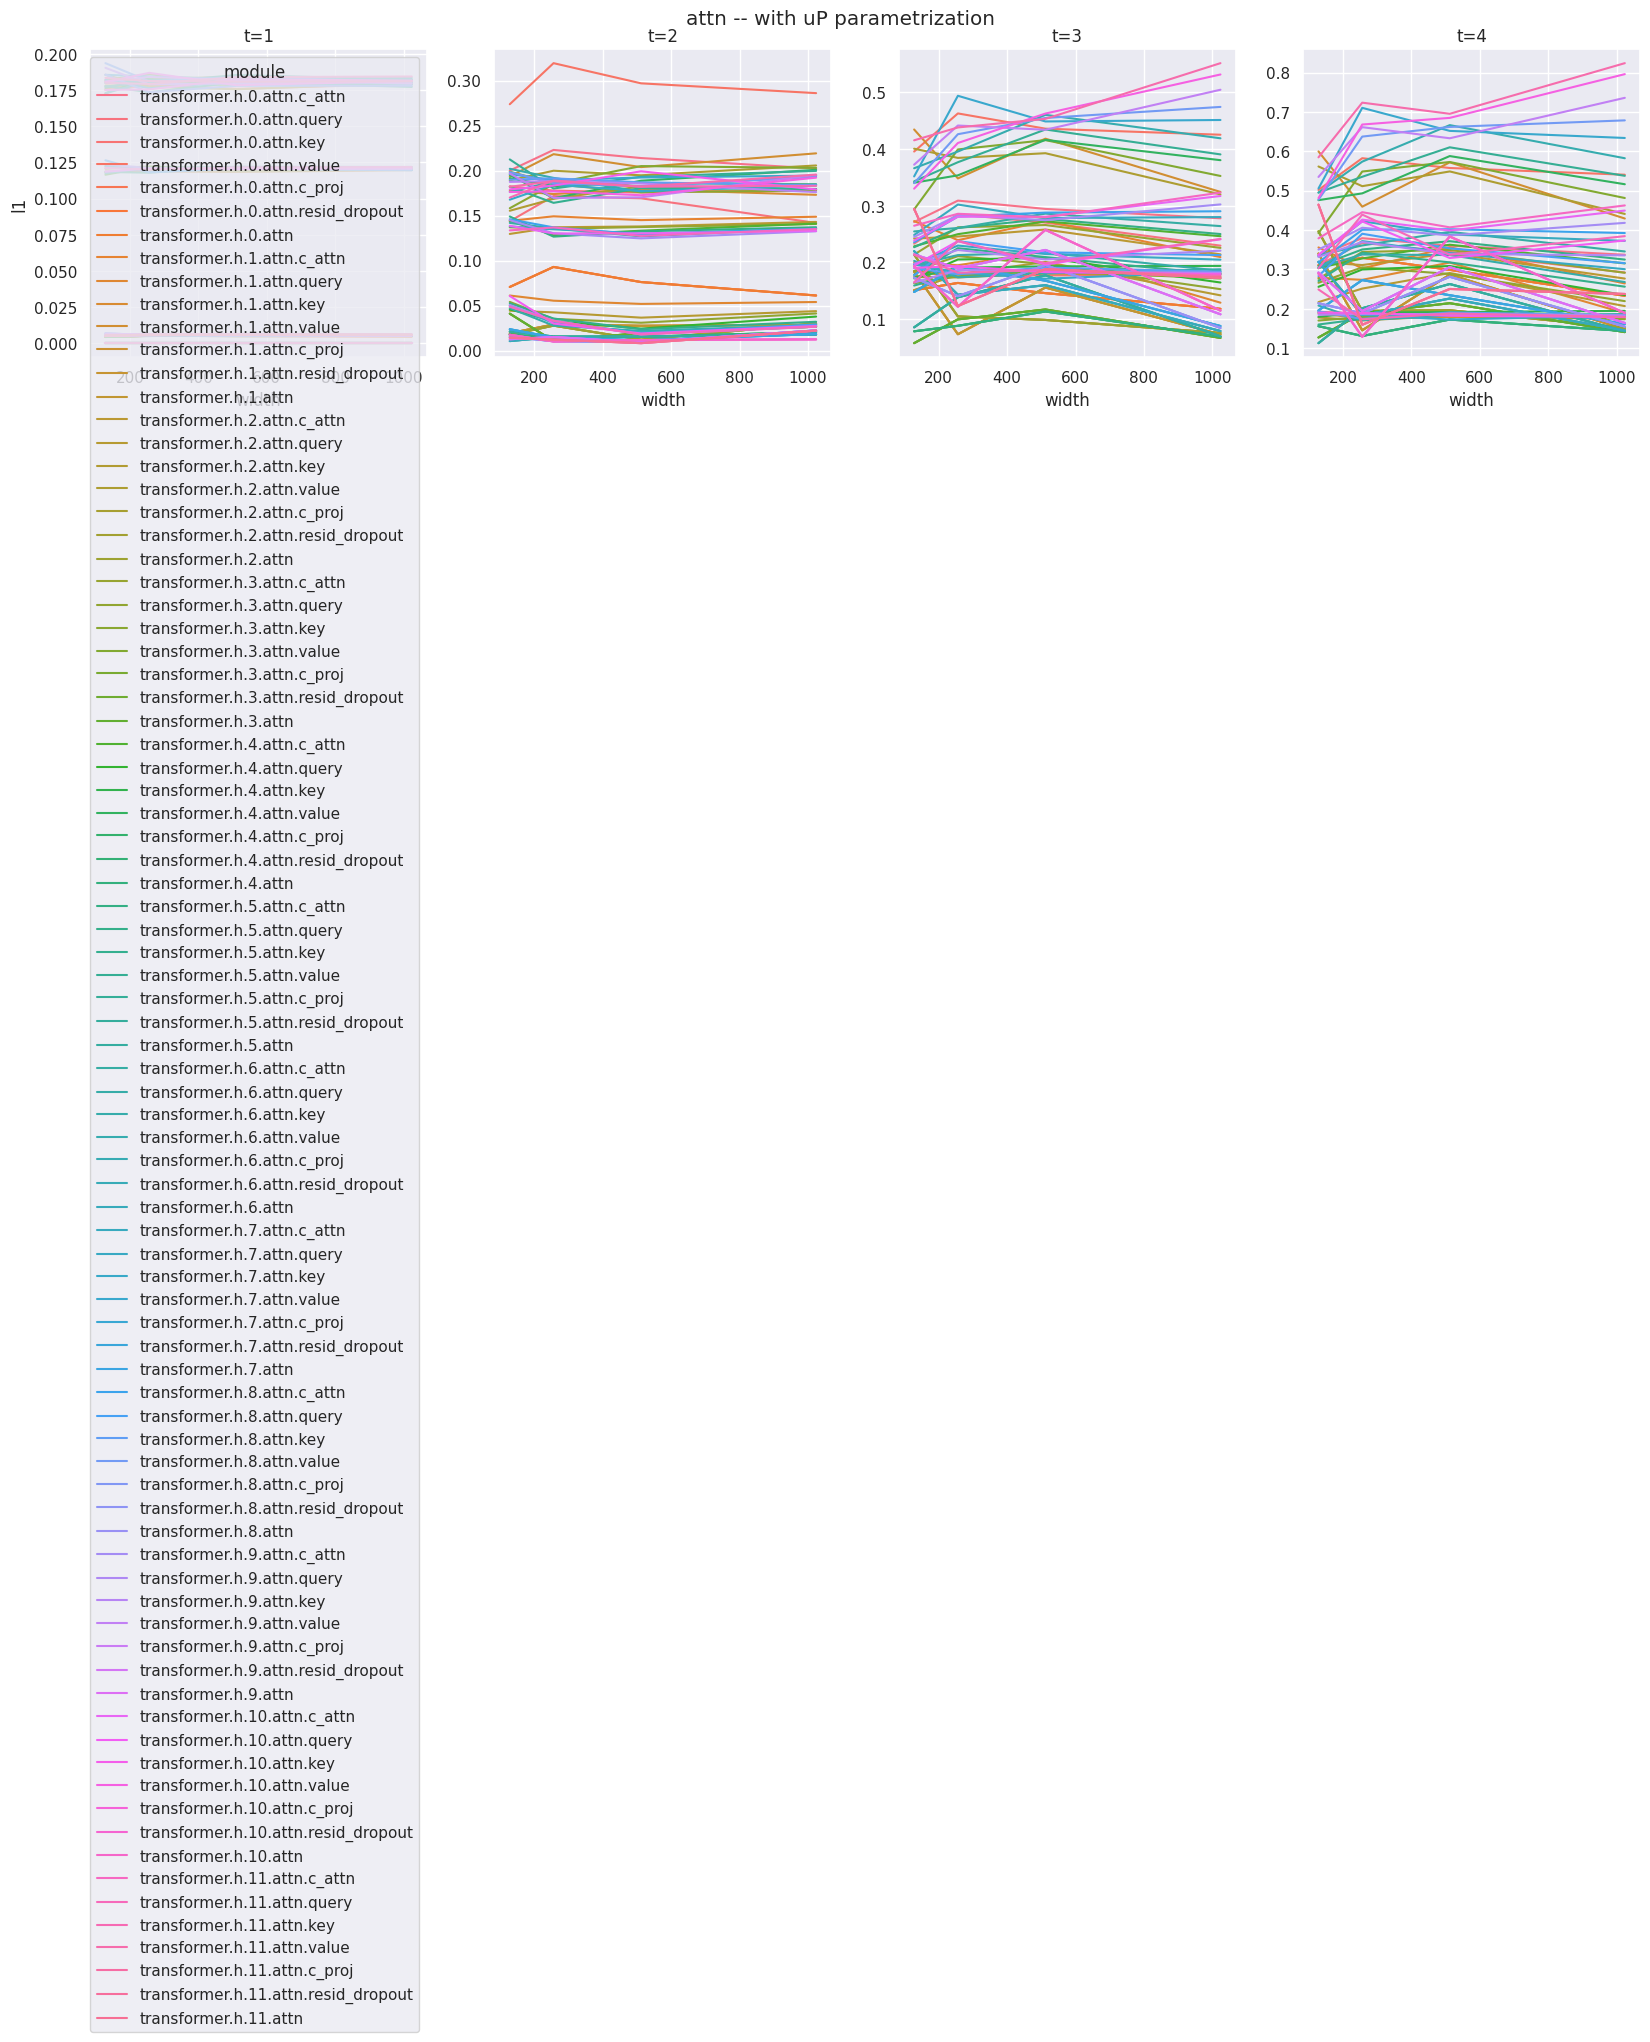

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


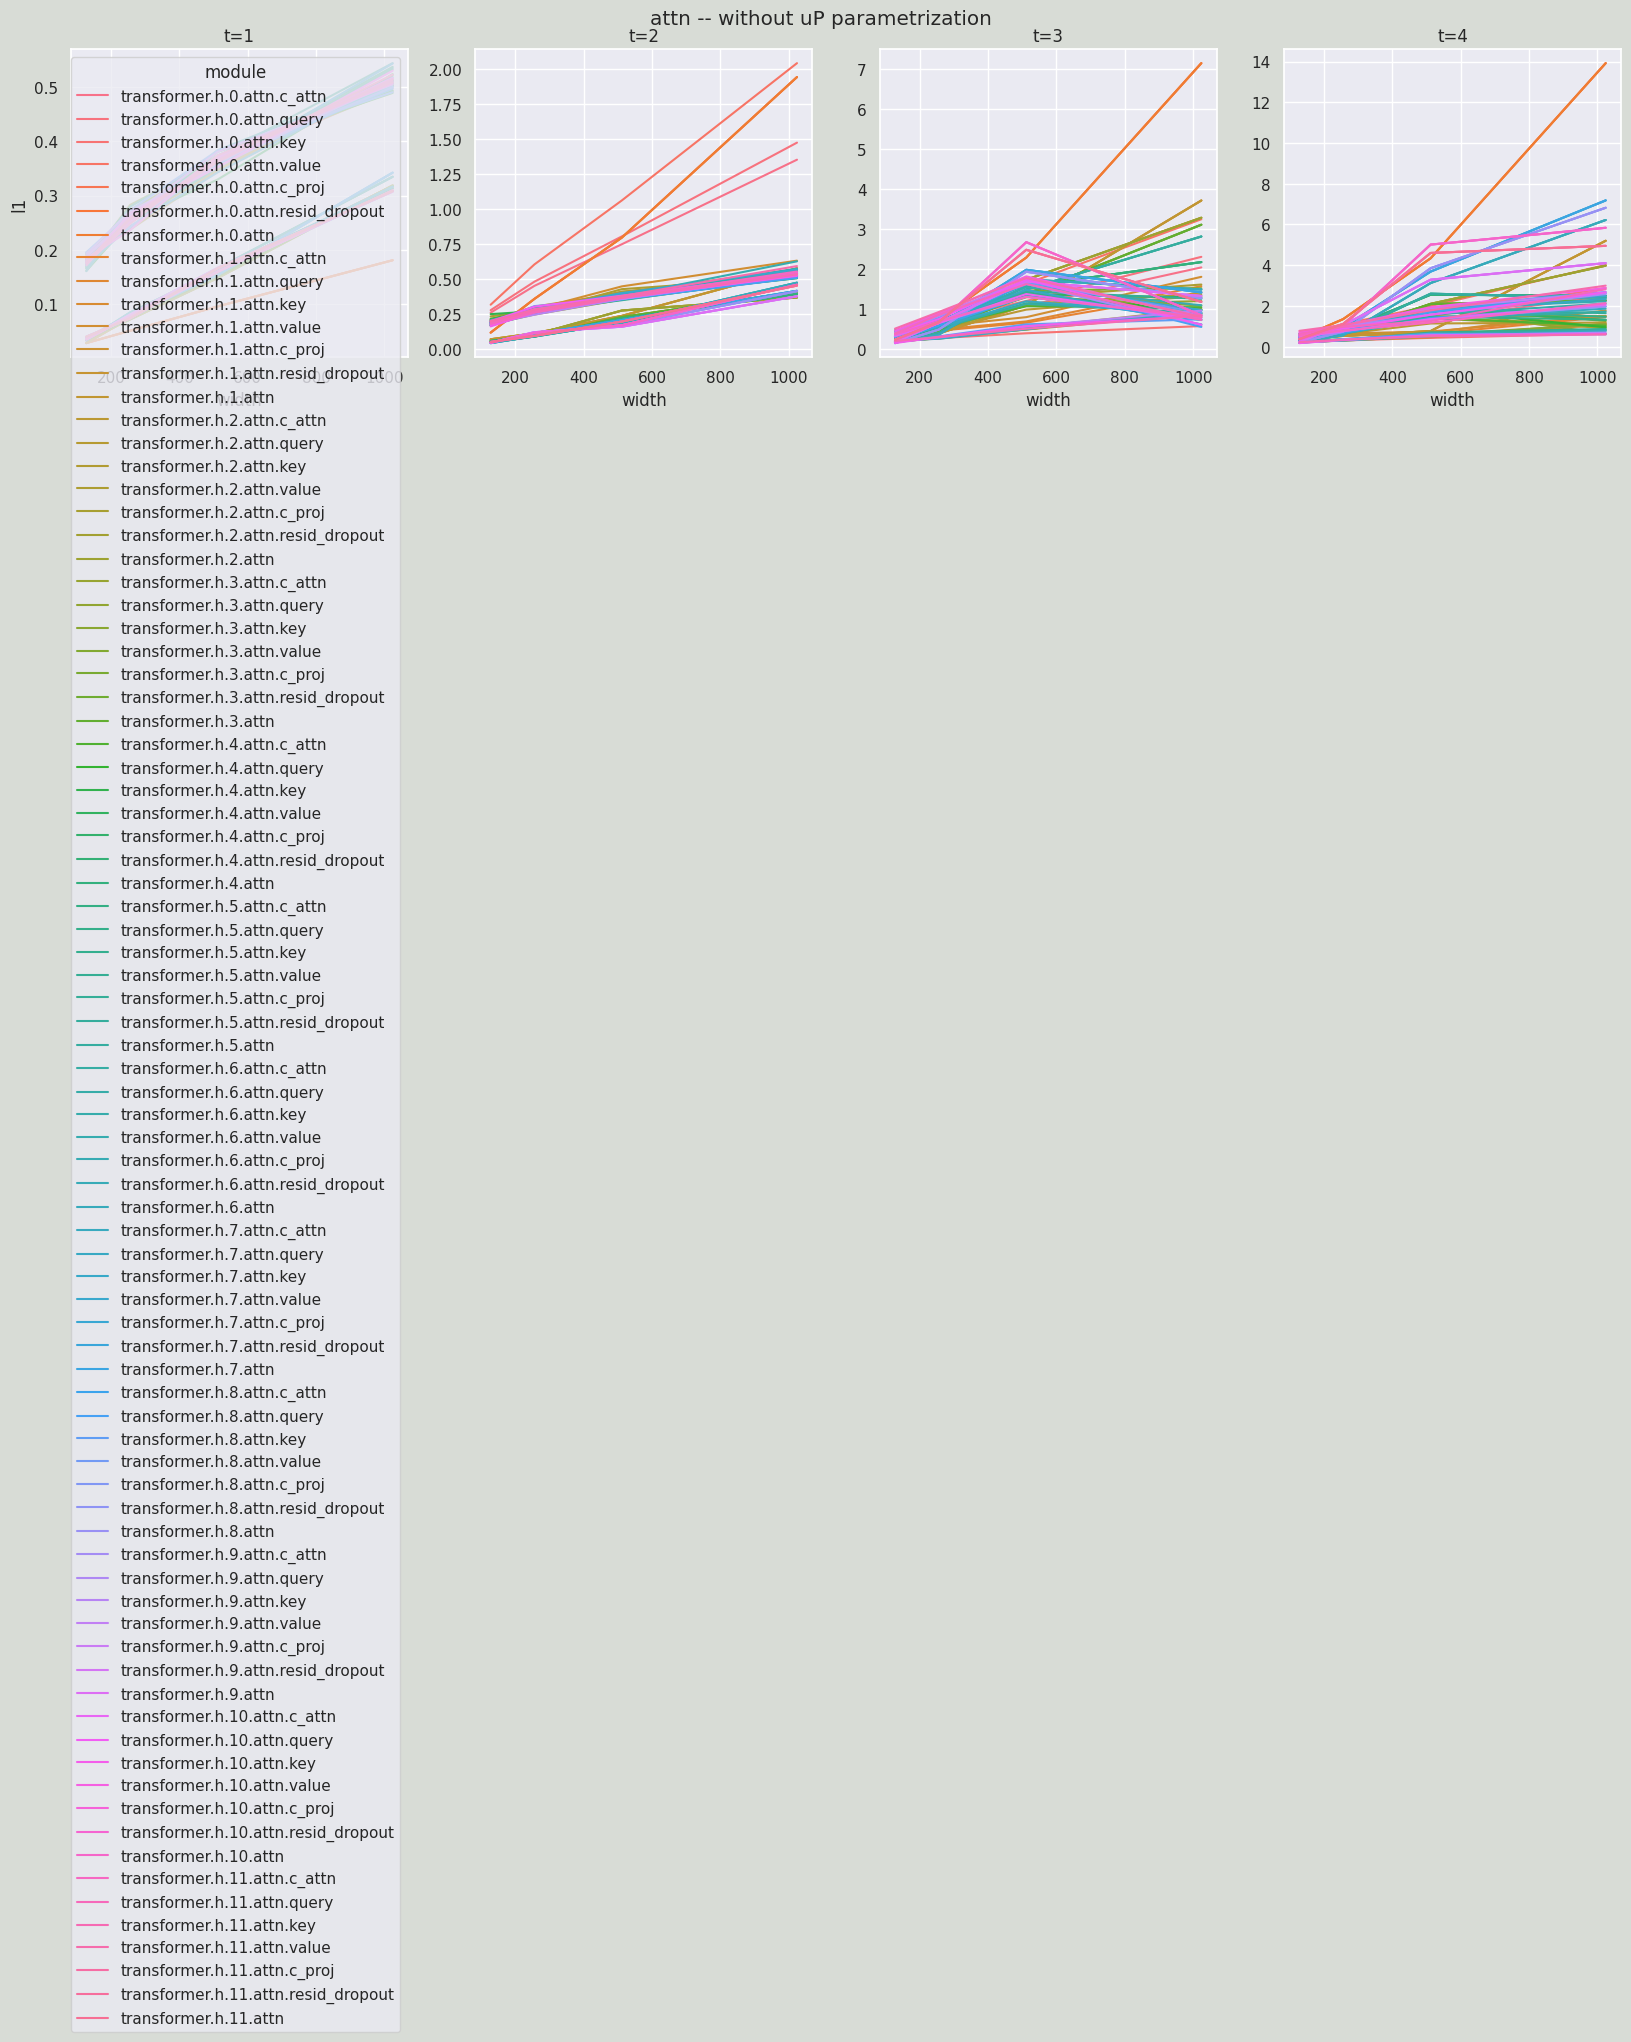

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


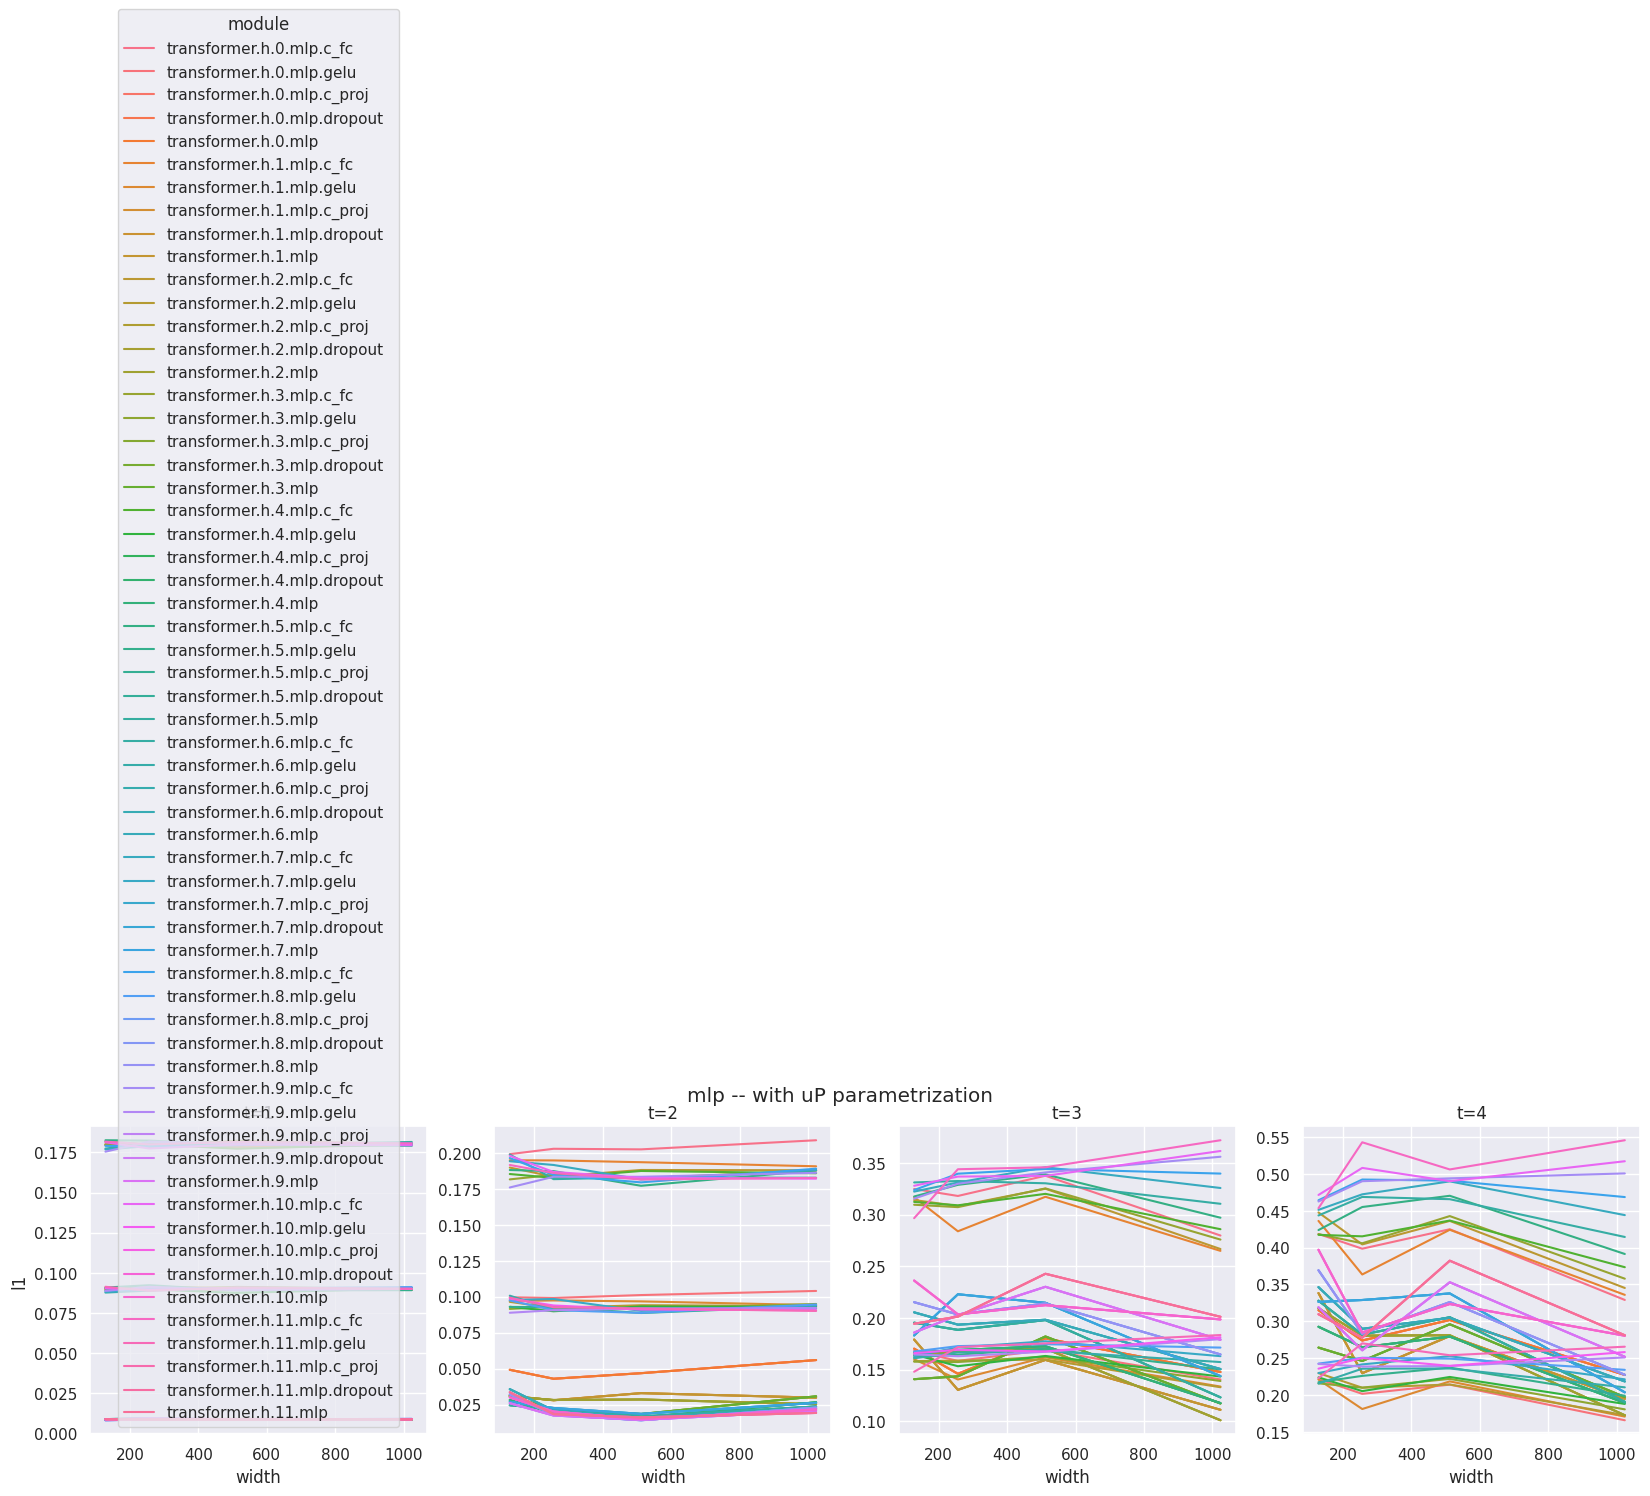

/home/fbartocc/.local/lib/python3.10/site-packages/mup/coord_check.py:489: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


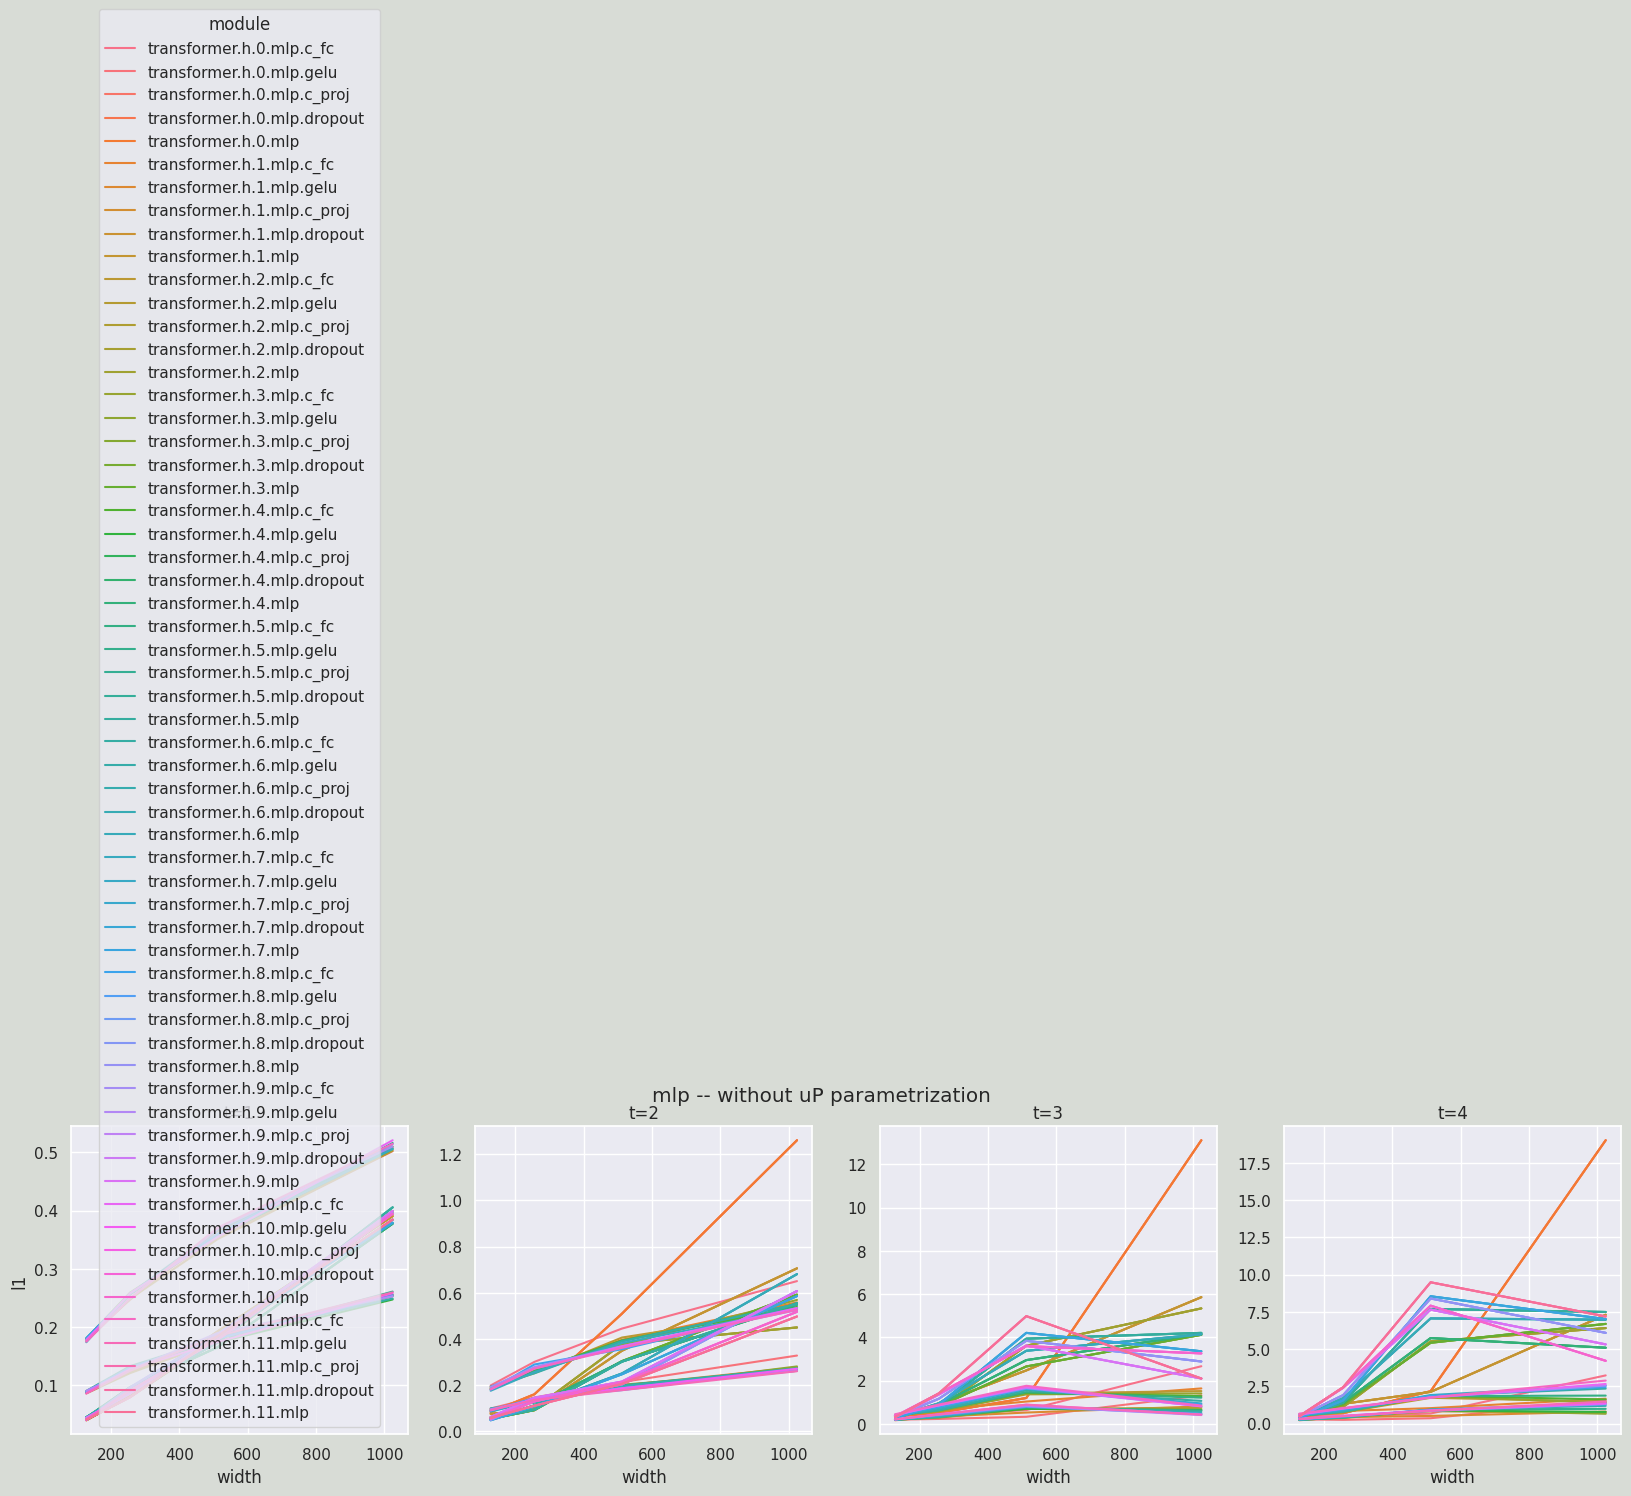

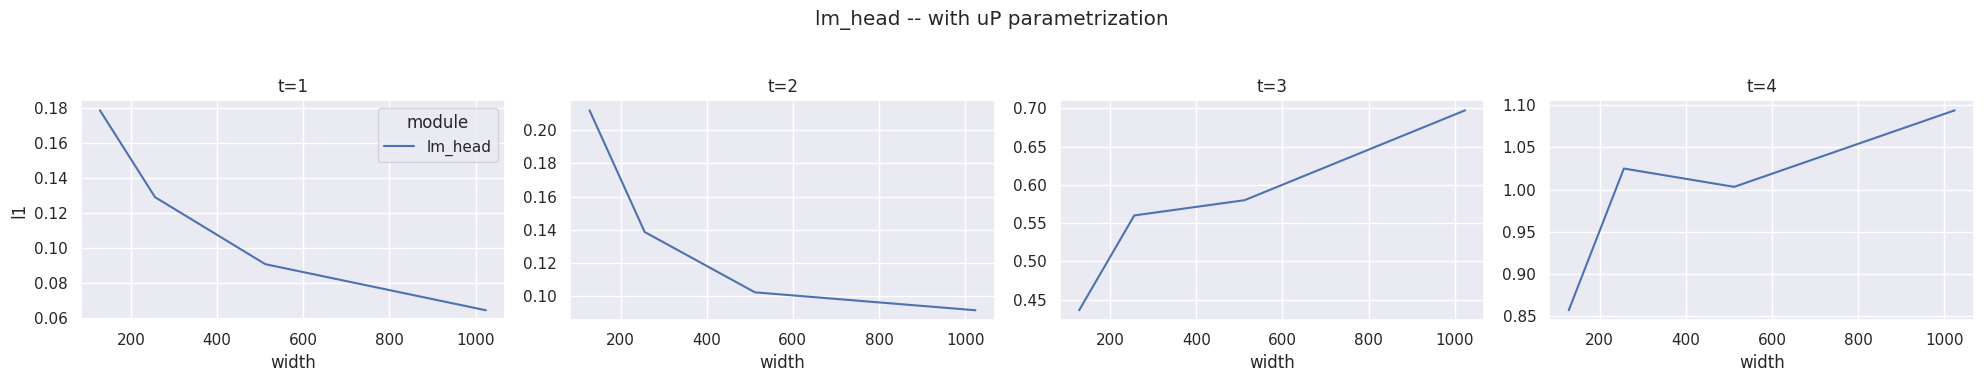

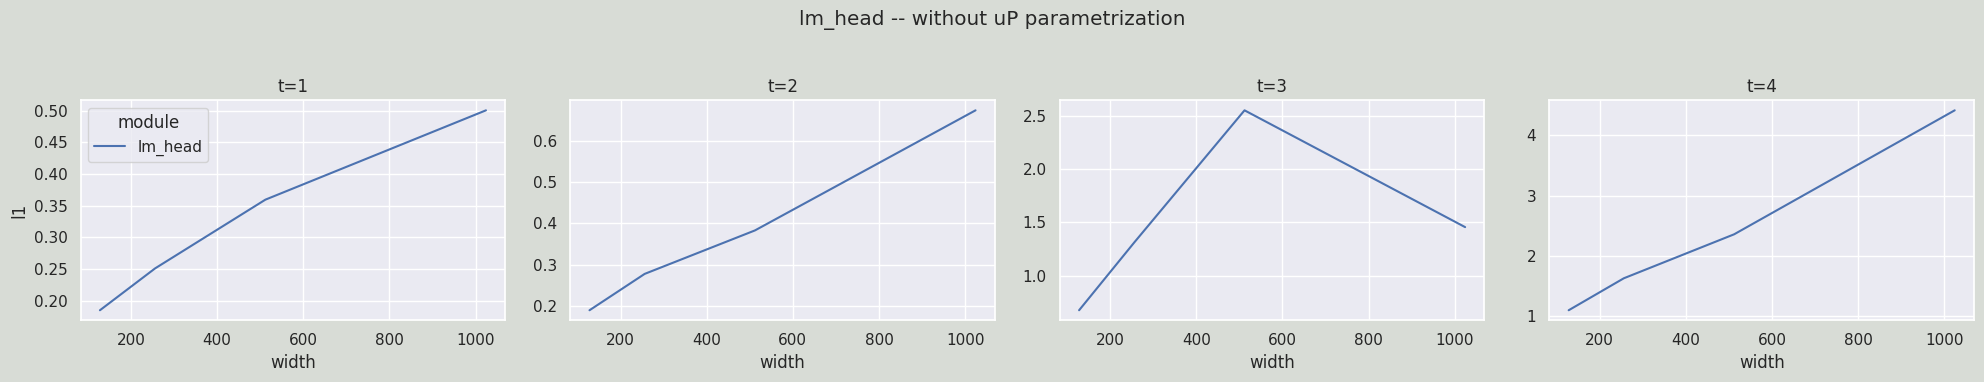

In [123]:
for layer_name in ['query', 'key', 'value', 'wie', 'wse', 'wte', 'attn_score', 'ln', 'attn', 'mlp', 'lm_head']:
    for is_mup in [True, False]:
        filtered_df = global_df[is_mup][global_df[is_mup]["module"].str.contains(layer_name)]
        plot_coord_data(
            filtered_df, 
            suptitle=f"{layer_name} -- with{'' if is_mup else 'out'} uP parametrization",
            face_color='xkcd:light grey' if not is_mup else None,
            loglog=False,
            logbase=2
        )
        plt.show()